# Analysis of poly(A) tail lengths on splice isoform basis

In [1]:
###Load Packages

#Functions for polyA specific analysis (must be in same path)
from polyA_utils import *

#Packages for general column manipulation and statistics
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
from scipy import stats
import scipy.stats as sci
import pysam

#Packages for plotting
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Color palettes for plotting

In [2]:
#Color palette for plots
four_palette = ["darkgreen", "tomato", "steelblue", "orange"]
two_palette = ["steelblue", "orange"]
IR_palette = ["goldenrod", "teal"]

Path to data

In [3]:
#path to the data
path = "path/to/data/"

In [4]:
figpath = "./"

In [5]:
#Function to read in reads dataframe
def read_polyA_reads(file, min_read_count, sample_name, replicate):
    df = pd.read_csv(file, delimiter='\t')
    df = df.loc[df['tail_len'] >= min_read_count]
    df['Sample'] = sample_name
    df['Replicate'] = replicate
    return(df)

In [6]:
#Read in dfs for all reads - annotated to mapped isoform instead of mapped gene
min_A_count = 10

h112_1 = read_polyA_reads(path + 'results/polyA_len/isoforms/isoforms_h112.R1_polyA.txt', min_A_count, "EV", "1")
h112_2 = read_polyA_reads(path + 'results/polyA_len/isoforms/isoforms_h112.R2_polyA.txt', min_A_count, "EV", "2")

h113_1 = read_polyA_reads(path + 'results/polyA_len/isoforms/isoforms_h113.R1_polyA.txt', min_A_count, "WT", "1")
h113_2 = read_polyA_reads(path + 'results/polyA_len/isoforms/isoforms_h113.R2_polyA.txt', min_A_count, "WT", "2")

h115_1 = read_polyA_reads(path + 'results/polyA_len/isoforms/isoforms_h115.R1_polyA.txt', min_A_count, "4SA", "1")
h115_2 = read_polyA_reads(path + 'results/polyA_len/isoforms/isoforms_h115.R2_polyA.txt', min_A_count, "4SA", "2")

h117_1 = read_polyA_reads(path + 'results/polyA_len/isoforms/isoforms_h117.R1_polyA.txt', min_A_count, "4SD", "1")
h117_2 = read_polyA_reads(path + 'results/polyA_len/isoforms/isoforms_h117.R2_polyA.txt', min_A_count, "4SD", "2")

#Path to gene types df (from gtf)
gene_types = pd.read_csv(path + "config/gene_types_df.tsv", sep = "\t")

# #Combine replicates and intersect with gene names
all_reads = pd.concat([h112_1, h112_2, h113_1, h113_2, h115_1, h115_2, h117_1, h117_2], ignore_index = True)


In [7]:
#Function to read polyA tab del files AFTER running get_tails.py
def read_polyA_gene(file, sample_name, replicate):
    df = pd.read_csv(file, delimiter='\t')
    df['Sample'] = sample_name
    df['Replicate'] = replicate
    return(df)

In [8]:
# load the results from tab del files for isoform specific mapping
per_gene_h112_1 = read_polyA_gene(path + "results/polyA_len/per_gene/isoforms_h112.R1_per_gene.tsv", "EV", "1")
per_gene_h112_2 = read_polyA_gene(path + "results/polyA_len/per_gene/isoforms_h112.R2_per_gene.tsv", "EV", "2")

per_gene_h113_1 = read_polyA_gene(path + "results/polyA_len/per_gene/isoforms_h113.R1_per_gene.tsv", "WT", "1")
per_gene_h113_2 = read_polyA_gene(path + "results/polyA_len/per_gene/isoforms_h113.R2_per_gene.tsv", "WT", "2")

per_gene_h115_1 = read_polyA_gene(path + "results/polyA_len/per_gene/isoforms_h115.R1_per_gene.tsv", "4SA", "1")
per_gene_h115_2 = read_polyA_gene(path + "results/polyA_len/per_gene/isoforms_h115.R2_per_gene.tsv", "4SA", "2")

per_gene_h117_1 = read_polyA_gene(path + "results/polyA_len/per_gene/isoforms_h117.R1_per_gene.tsv", "4SD", "1")
per_gene_h117_2 = read_polyA_gene(path + "results/polyA_len/per_gene/isoforms_h117.R2_per_gene.tsv", "4SD", "2")

#Concatenate samples and conditions into single dataframes
df_isos = pd.concat([per_gene_h112_1, per_gene_h112_2, per_gene_h113_1, per_gene_h113_2, per_gene_h115_1, per_gene_h115_2, per_gene_h117_1, per_gene_h117_2])

df_isos = df_isos.loc[df_isos['median'] >= 10]
df_isos.rename(columns={"Unnamed: 0":'iso_id'}, inplace=True)

#Path to gene types df (from gtf)
gene_types = pd.read_csv("/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/config/gene_types_df.tsv", sep = "\t")
df_isos["gene_id"] = df_isos.iso_id.str.split("_").str[-1].str.split(".").str[0]

#Combine replicates and intersect with gene names
df_isos = df_isos.merge(gene_types, on = 'gene_id')

In [9]:
#Determine which isoforms have retained introns using flair mark IR tool
mark_IR = pd.read_csv("/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/splicing/IR/IR_isoforms.bed", sep = "\t", header = None)
IR_isoforms = list(mark_IR.loc[mark_IR[12] == 1][3])

df_isos.loc[df_isos.iso_id.isin(IR_isoforms), "IR"] = "IR"
df_isos.loc[~df_isos.iso_id.isin(IR_isoforms), "IR"] = "Spliced"

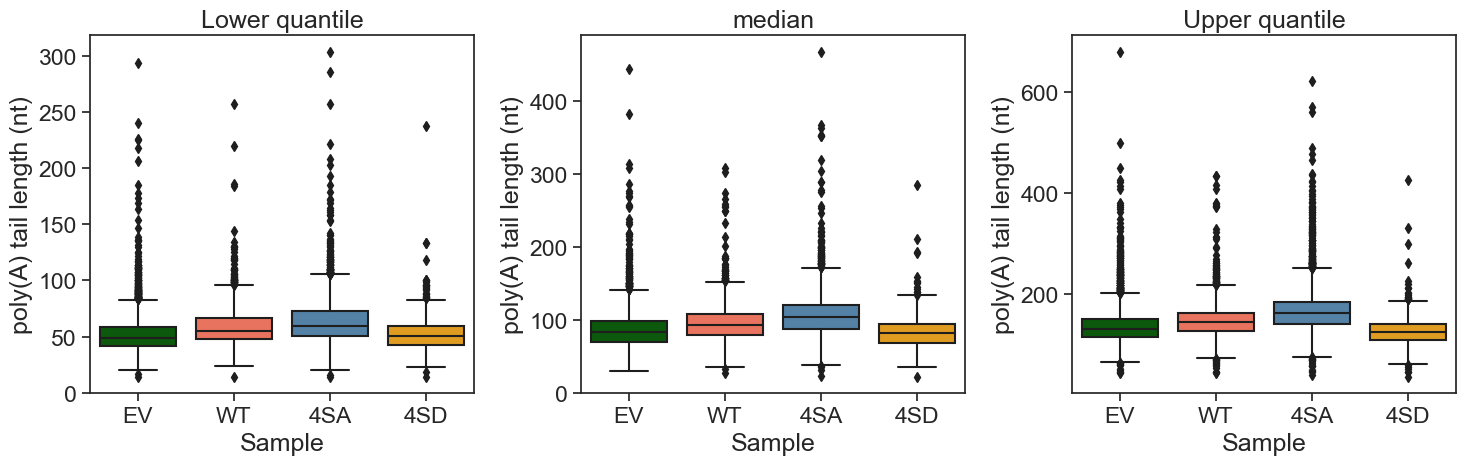

In [10]:
#Compare tail length distributions across conditions - MEDIAN
plot_samps = ["EV", "WT", "4SA", "4SD"]
plot_df = df_isos.loc[df_isos['Sample'].isin(plot_samps)]

fig, (ax1) = plt.subplots(1,3, figsize = (15, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

#plot
#Lower quantile (25 percent)
sns.boxplot(data=plot_df, x="Sample", y="quantile_25", 
             palette = four_palette, ax = ax1[0], hue_order = plot_samps, order = plot_samps 
             ).set(title = 'Lower quantile')

#Median
sns.boxplot(data=plot_df, x="Sample", y="median", 
             palette = four_palette, ax = ax1[1], hue_order = plot_samps, order = plot_samps 
             ).set(title = 'median')

#Upper quantile (75 percent)
sns.boxplot(data=plot_df, x="Sample", y="quantile_75", 
             palette = four_palette, ax = ax1[2], hue_order = plot_samps, order = plot_samps 
             ).set(title = 'Upper quantile')

ax1[0].set_xlabel("Sample")
ax1[1].set_xlabel("Sample")
ax1[2].set_xlabel("Sample")

ax1[0].set_ylabel("poly(A) tail length (nt)")
ax1[1].set_ylabel("poly(A) tail length (nt)")
ax1[2].set_ylabel("poly(A) tail length (nt)")

fig.tight_layout()

Are there any differences in tailing of IR isoforms between mutants?

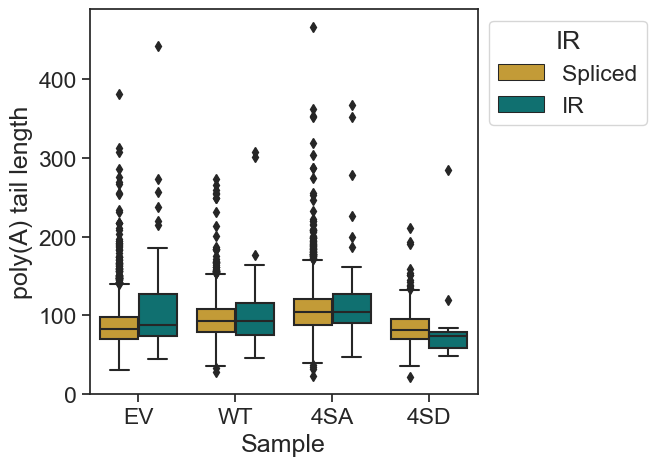

In [11]:
fig, ax = plt.subplots(1,1, figsize = (5, 5))

sns.boxplot(data=plot_df, x="Sample", y="median", 
             palette = IR_palette, order = plot_samps, hue = "IR" 
             )

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("Sample")
ax.set_ylabel("poly(A) tail length")

plt.savefig(figpath + 'tails_per_splice_isoform.png', dpi=300, bbox_inches="tight")

Look back at all reads to do spliced to unspliced comparisons of tail lengths

In [12]:
#Reformat the all_reads df to contain info on gene types
all_reads.loc[all_reads.gene_id.isin(IR_isoforms), "IR"] = "IR"
all_reads.loc[~all_reads.gene_id.isin(IR_isoforms), "IR"] = "Spliced"
all_reads = all_reads.rename(columns={"gene_id": "iso_id"})
all_reads["gene_id"] = all_reads.iso_id.str.split("_").str[-1].str.split(".").str[0]
all_reads = all_reads.merge(gene_types, on = 'gene_id')

Generate a list of gene ids with at least 20 reads that map to IR isoforms

In [13]:
list(np.unique(all_reads.loc[all_reads.IR == "IR"].gene_name.value_counts().loc[lambda x : x>=20].index))

['AC015813.2',
 'AC048338.1',
 'ACOT9',
 'ACTG1',
 'APH1A',
 'AUP1',
 'BAZ1B',
 'BORCS7',
 'C12orf10',
 'C16orf70',
 'C2orf49',
 'CBS',
 'CBWD5',
 'CCNA2',
 'CDCA3',
 'CEBPZ',
 'CHMP2A',
 'CLIC1',
 'CNBP',
 'CPT1B',
 'CTNNB1',
 'CUTA',
 'DHCR24',
 'DMKN',
 'DPM2',
 'DUS1L',
 'EBNA1BP2',
 'EEF1A1',
 'EIF3G',
 'EIF4A1',
 'EIF4A2',
 'EMC9',
 'EWSR1',
 'EXOSC8',
 'FAN1',
 'FDPS',
 'GAPDH',
 'GAS5',
 'GLA',
 'GTF2H1',
 'HLA-A',
 'HNRNPH1',
 'HSPA8',
 'IDH3B',
 'JTB',
 'KIF22',
 'KRR1',
 'KXD1',
 'METTL17',
 'MOV10',
 'MRPL17',
 'MRPL43',
 'MYBBP1A',
 'NDUFS8',
 'NELFE',
 'NONO',
 'NOP56',
 'NPM1',
 'NR2C2AP',
 'OAZ1',
 'OXSM',
 'PAFAH1B3',
 'PCID2',
 'PFDN6',
 'PHB2',
 'POLR2I',
 'PPP1CC',
 'PPP1R14B',
 'PSMC4',
 'RABEPK',
 'RACK1',
 'RANBP1',
 'RANGRF',
 'RARS2',
 'RNF181',
 'RPAIN',
 'RPL10',
 'RPL10A',
 'RPL13',
 'RPL13A',
 'RPL17',
 'RPL22L1',
 'RPL3',
 'RPL30',
 'RPL4',
 'RPL41',
 'RPL7A',
 'RPL9',
 'RPLP0',
 'RPS11',
 'RPS16',
 'RPS3A',
 'RPS4X',
 'RPS8',
 'SAT1',
 'SEC62',
 'SHMT2',


Make boxplot for gene(s) of interest - all in EV for proof of principle

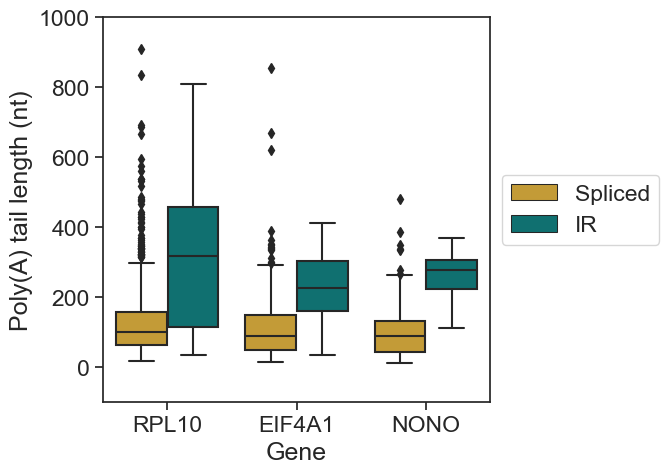

In [14]:
#Plot to compare tail lengths of spliced to unspliced isoforms
gene_list = ["RPL10", "EIF4A1", "NONO"]
condition1 = "4SA"
comparision = "tail_len"
Sample = "Sample"

reads_to_plot = all_reads.loc[(all_reads["gene_name"].isin(gene_list))]
reads_to_plot = reads_to_plot.loc[(reads_to_plot["Sample"] == condition1)] 

# Plot with seaborn
f, (ax) = plt.subplots(1,1, figsize = (5, 5))

sns.boxplot(data=reads_to_plot, x = "gene_name", y = "tail_len", hue = "IR", palette = IR_palette, order = gene_list)
ax.set_ylabel("Poly(A) tail length (nt)")
ax.set_xlabel("Gene")
ax.set_ylim(-100, 1500)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-100, 1000)

plt.savefig(figpath + 'tails_per_splice_isoform_select_genes.png', dpi=300, bbox_inches="tight")

Statistical test on per-isoform basis

In [15]:
gene_list = ["RPL10", "EIF4A1", "NONO"]
print("p-values")
for gene in np.unique(reads_to_plot.gene_name):
    s = stats.mannwhitneyu(list(reads_to_plot.loc[(reads_to_plot["IR"] == "IR") & (reads_to_plot["gene_name"] == gene)].tail_len), 
                    list(reads_to_plot.loc[(reads_to_plot["IR"] == "Spliced") & (reads_to_plot["gene_name"] == gene)].tail_len), 
                    axis=0)
    print(gene + ": " + str(s.pvalue))

p-values
EIF4A1: 3.15339509702419e-07
NONO: 0.0008998561146688448
RPL10: 5.9409845307655255e-06


In [16]:
#Define a function to compare tail lengths per gene between two conditions
def compare_tail_lengths(df, c1, c2, min_reads=25):
    #select genes that are common between conditions
    c1_genes = df.loc[df.Sample == c1].iso_id
    common_genes = list(np.unique(df.loc[(df.Sample == c2) & df.iso_id.isin(c1_genes)].iso_id ))
    #calculate summary stats of each gene between conditions and test for statistical significance 
    per_gene_res_c1 = dict()
    per_gene_res_c2 = dict()
    reads_c1 = df.loc[df["Sample"] == c1]
    reads_c2 = df.loc[df["Sample"] == c2]
    for i in tqdm(np.unique(common_genes)):
        temp_c1 = reads_c1[reads_c1.iso_id == i]
        temp_c2 = reads_c2[reads_c2.iso_id == i]
        if (len(temp_c1) & len(temp_c2)) >= min_reads:
            per_gene_res_c1[i] = [np.mean(temp_c1.tail_len), np.median(temp_c1.tail_len), pearson_skew_2(temp_c1.tail_len), len(temp_c1.tail_len)]
            per_gene_res_c2[i] = [np.mean(temp_c2.tail_len), np.median(temp_c2.tail_len), pearson_skew_2(temp_c2.tail_len), len(temp_c2.tail_len), np.unique(temp_c1.gene_name)[0], stats.mannwhitneyu(temp_c1.tail_len, temp_c2.tail_len).pvalue]
    
    #build a dataframe for results output
    per_gene_c1 = pd.DataFrame.from_dict(per_gene_res_c1, orient='index', columns=[('mean' + "_" + c1), 'median'+ "_" + c1, 'skew'+ "_" + c1, 'n'+ "_" + c1])
    per_gene_c2 = pd.DataFrame.from_dict(per_gene_res_c2, orient='index', columns=[('mean' + "_" + c2), 'median'+ "_" + c2, 'skew'+ "_" + c2, 'n'+ "_" + c2, "gene_name", "pvalue"])
    per_gene_df = per_gene_c1.join(per_gene_c2)
    #correct pvalues for sample size (BH correction)
    per_gene_df["FDR"] = stats.false_discovery_control(per_gene_df["pvalue"])
    per_gene_df["log2FC"] = np.log2(per_gene_df["median_" + c2]/per_gene_df["median_" + c1])
    
    return(per_gene_df)

In [17]:
#Run the comparison function
SA_v_SD = compare_tail_lengths(all_reads, "4SD", "4SA", 10)

  0%|                                                                                                                                                                                                    | 0/7105 [00:00<?, ?it/s]Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7105/7105 [02:58<00:00, 39.76it/s]


In [18]:
#Reintigrate the info about intron retention
SA_v_SD.loc[SA_v_SD.index.isin(IR_isoforms), "IR"] = "IR"
SA_v_SD.loc[~SA_v_SD.index.isin(IR_isoforms), "IR"] = "Spliced"

In [19]:
#Define a pvalue and FC cut for plotting
pcut = 0.05
FC_cut = 0

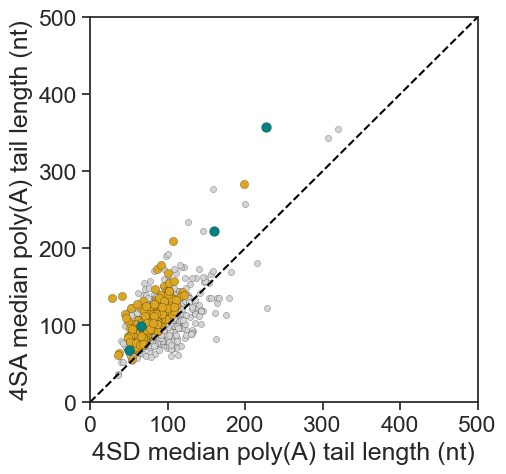

In [20]:
#4SD vs 4SD
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.scatterplot(data = SA_v_SD, x = "median_4SD", y = "median_4SA", s = 20, alpha = 1, color = "lightgrey", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = SA_v_SD.loc[(SA_v_SD["IR"] == "Spliced") & (SA_v_SD["FDR"] <= 0.05)], x = "median_4SD", y = "median_4SA", color = IR_palette[0], edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = SA_v_SD.loc[(SA_v_SD["IR"] == "IR") & (SA_v_SD["FDR"] <= 0.05)], x = "median_4SD", y = "median_4SA", color = IR_palette[1], edgecolor = "black", linewidth = 0.15, s = 50)

sns.lineplot(x = [0,500], y = [0,500], color = "black", linestyle = "--")

ax.set_xlim(0,500)
ax.set_ylim(0,500)

ax.set_xlabel("4SD median poly(A) tail length (nt)")
ax.set_ylabel("4SA median poly(A) tail length (nt)")

plt.savefig(figpath + 'tails_per_splice_isoform_4SAv4SD.png', dpi=300, bbox_inches="tight")

In [21]:
len(SA_v_SD.loc[(SA_v_SD["IR"] == "Spliced") & (SA_v_SD["FDR"] <= 0.05)])

231

In [22]:
len(SA_v_SD.loc[(SA_v_SD["IR"] == "IR") & (SA_v_SD["FDR"] <= 0.05)])

4

In [29]:
len(SA_v_SD.loc[(SA_v_SD["FDR"] <= 0.05)])

235

Some intron retained RNAs have longer tails, but for the most part, fully spliced RNAs are being hyperadenylated in the 4SA mutant. 

In [23]:
path

'/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/'

In [31]:
isoforms = pd.read_csv(path + "results/splicing/collpase/all.isoforms.bed", sep = "\t", header = None)
isoforms.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,chr1,14403,14793,m64146_210430_195255/133497152/ccs_chr1:14000,60,-,14403,14793,5,1,"390,","0,"
1,chr1,20529,21421,m64146_210812_153541/68618961/ccs_chr1:20000,1,-,20529,21421,1,1,"892,","0,"
2,chr1,145812,147709,m64146_210430_195255/2885599/ccs_chr1:145000,0,-,145812,147709,1,1,"1897,","0,"
3,chr1,184919,186383,m64146_210812_153541/142542995/ccs_chr1:184000,6,-,184919,186383,1,1,"1464,","0,"
4,chr1,187379,188288,m64146_210812_153541/55838572/ccs_chr1:187000,36,-,187379,188288,1,1,"909,","0,"


In [96]:
isoforms["exon_count"] = isoforms[10].str.split(",").str[:-1].str.len()

In [98]:
isoforms = isoforms.rename(columns = {3: "iso_id"})
isoforms = isoforms[["iso_id", "exon_count"]]

In [99]:
isoforms

,iso_id,exon_count
0,m64146_210430_195255/133497152/ccs_chr1:14000,1
1,m64146_210812_153541/68618961/ccs_chr1:20000,1
2,m64146_210430_195255/2885599/ccs_chr1:145000,1
3,m64146_210812_153541/142542995/ccs_chr1:184000,1
4,m64146_210812_153541/55838572/ccs_chr1:187000,1
...,...,...
46567,ENST00000381401.11_PAR_Y_ENSG00000169100.14-PAR-Y,4
46568,ENST00000286448.12_PAR_Y_ENSG00000124333.16-PAR-Y,8
46569,m64146_210430_195255/123667285/ccs_ENSG0000018...,3
46570,m64146_210430_195255/165545085/ccs_ENSG0000016...,8


In [101]:
SA_v_SD["iso_id"] = SA_v_SD.index

In [103]:
SA_v_SD_2 = SA_v_SD.merge(isoforms, on = "iso_id")
SA_v_SD_2.head()

,mean_4SD,median_4SD,skew_4SD,n_4SD,mean_4SA,median_4SA,skew_4SA,n_4SA,gene_name,pvalue,FDR,log2FC,IR,iso_id,exon_count
0,194.428571,228.5,-1.157288,14,159.673913,122.5,1.041423,46,ARF5,0.195836,0.331848,-0.899412,Spliced,ENST00000000233.10_ENSG00000004059.11,6
1,73.800000,59.5,0.915597,10,119.765957,84.0,1.166512,47,M6PR,0.147637,0.274753,0.497500,Spliced,ENST00000000412.8-1_ENSG00000003056.8,7
2,127.163265,113.0,0.651022,49,171.025641,145.0,0.709273,117,CD9,0.031629,0.093537,0.359730,Spliced,ENST00000009180.10_ENSG00000010278.15,8
3,85.131980,68.0,1.070208,197,111.916239,89.0,0.794158,585,RPS20,0.000035,0.000440,0.388271,Spliced,ENST00000009589.8_ENSG00000008988.11,4
4,92.591837,81.0,0.584453,49,113.424000,98.0,0.564882,125,PSMA4,0.126213,0.249099,0.274860,Spliced,ENST00000044462.12_ENSG00000041357.16,9


<Axes: xlabel='exon_count', ylabel='log2FC'>

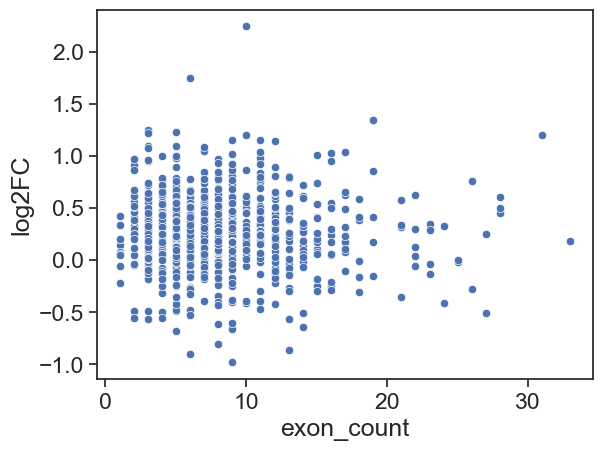

In [109]:
sns.scatterplot(SA_v_SD_2, x = "exon_count", y = "log2FC")